In [97]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
y_train = tf.one_hot(y_train, depth=10).numpy()
y_test = tf.one_hot(y_test, depth=10).numpy()

In [154]:
x_train, x_test = x_train.reshape(x_train.shape[0], -1), x_test.reshape(x_test.shape[0], -1)

ガウスフィルタ

In [168]:
class Signals:
    def __init__(self):
        self.high = []        # high resolution singals
        self.low = []         # low resolution signals
        self.ista = []        # recovered signals with ISTA
        self.lista = []       # recovered signals with LISTA

In [169]:
# training data
ntr = 500
train = Signals()
for i in range(5):
    idx = np.where(y_train[:, i] == 1)[0][:ntr]
    train.high.append(x_train[idx, :])
train.high = np.array(train.high)
print(train.high.shape)

(5, 500, 784)


In [170]:
nte = 500
test = Signals()
for i in range(10):
    idx = np.where(y_test[:, i] == 1)[0]
    test.high.append(x_test[idx[-nte:], :])
test.high = np.array(test.high)
print(test.high.shape)

(10, 500, 784)


In [172]:
# low resolution signals by bluring using gauss kernel
width = 4
s = 16.0
a = np.abs(np.arange(-width, width+1)[:, np.newaxis])
dist = a**2 + (a**2).T
kernel = np.exp(-dist / (2 * s)) / (2 * np.pi * s)
A = np.zeros((784, 784))
c = 0
for i in range(28):
    for j in range(28):
        a = np.zeros((28+2*width, 28+2*width))
        for k in range(2*width+1):
            a[i+k, j:j+(2*width+1)] = kernel[k, :]
        A[c, :] = a[width:-width, :][:, width:-width].flatten()
        c += 1
for i in range(train.high.shape[0]):
    train.low.append(train.high[i, :, :].dot(A.T))
train.low = np.array(train.low)
for i in range(test.high.shape[0]):
    test.low.append(test.high[i, :, :].dot(A.T))
test.low = np.array(test.low)
print(train.low.shape, test.low.shape)

(10, 500, 784) (10, 500, 784)


### ISTA
$ \hat{x} = {\rm argmin} \frac{1}{2} \| b - Ax\| + \lambda \| x \|_1$  
$ g_t = A^T (A x_{t -1} - b)$  
$ x_t = S_{\eta \lambda}(x_{t - 1} - \eta g_t) = S_{\eta \lambda} ((I - A^T A ) x_{t -1} + A^T A b)$

In [139]:
def ista(A, x, rho=0.1, max_iter=500, tol=1e-5):
    d = A.shape[1]
    m = A.shape[0]
    rho *= m
    s = np.linalg.svd(A, full_matrices=False, compute_uv=False)
    eta = 1 / np.max(s**2)
    z = np.zeros(d)
    obj = 0.5 * np.sum((A.dot(z) - x)**2) + rho * np.sum(np.abs(z))
    for itr in range(max_iter):
        gi = A.T.dot(A.dot(z) - x)
        zi = z - eta * gi
        z_new = np.sign(zi) * np.maximum(0.0, np.abs(zi) - rho * eta)
        z_new = np.maximum(0.0, z_new)
        obj_new = 0.5 * np.sum((A.dot(z_new) - x)**2) + rho * np.sum(np.abs(z_new))
        if obj - obj_new < tol:
            break
        z = z_new
        obj = obj_new
    return z

In [140]:
def recover(signals, A, rho=1e-2):
    signals.ista = []
    for i in range(signals.low.shape[0]):
        print(i)
        yi = []
        for j in range(signals.low.shape[1]):
            yij = ista(A, signals.low[i, j, :], rho=rho, max_iter=500)
            yi.append(yij)
        signals.ista.append(yi)
    signals.ista = np.array(signals.ista)
    return signals

In [145]:
np.array([
    np.arange(0, 9).reshape(3, 3),
    np.arange(0, 9).reshape(3, 3),
]).reshape(2, -1).shape

(2, 9)

In [176]:
rho = 1e-5
train_ista = recover(train, A, rho=rho)
print(train.ista.shape)

0
1
2
3
4
5
6
7
8
9
(10, 500, 784)


In [182]:
test = recover(test, A, rho=rho)
print(test.ista.shape)

0
1
2
3
4
5
6
7
8
9
(10, 500, 784)


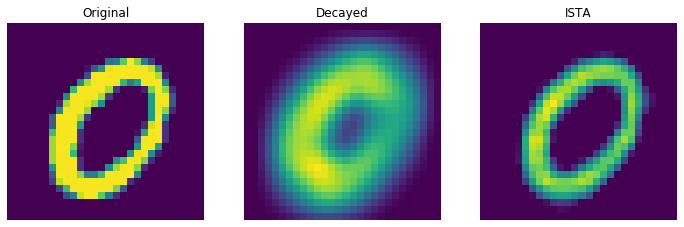

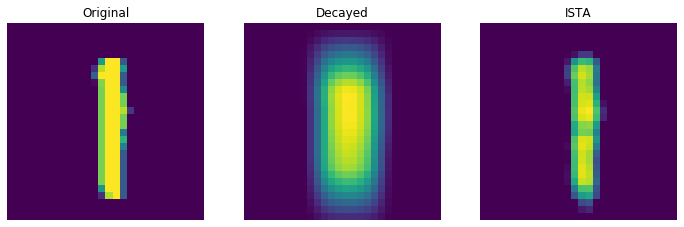

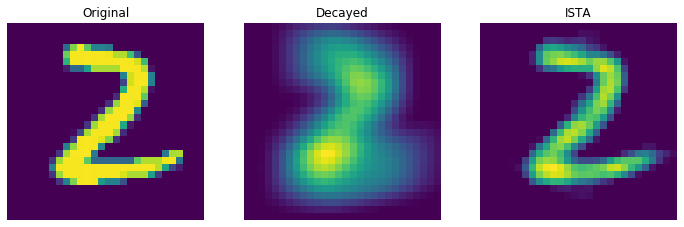

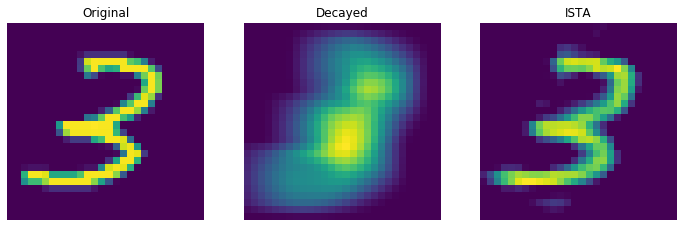

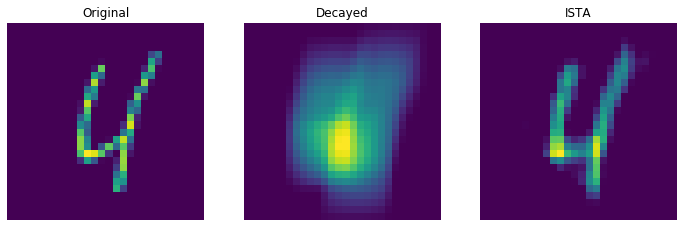

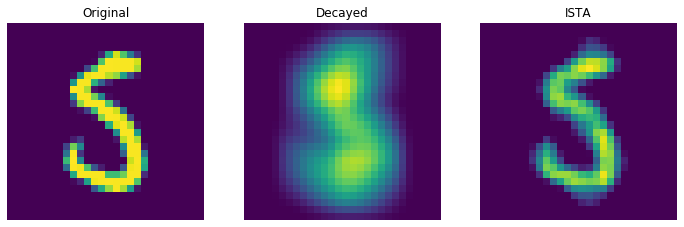

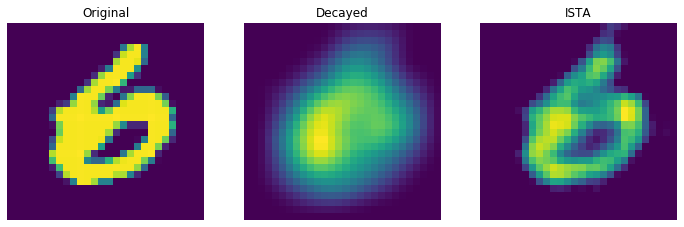

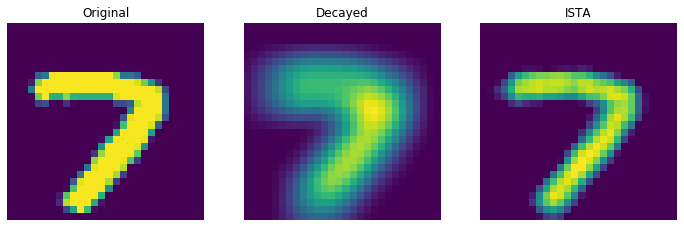

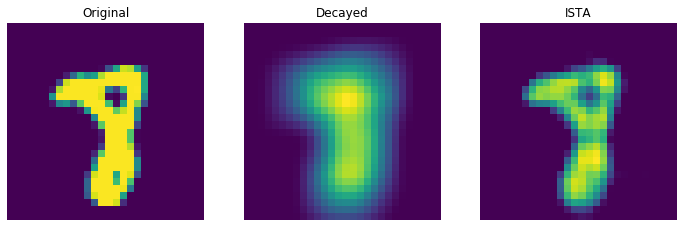

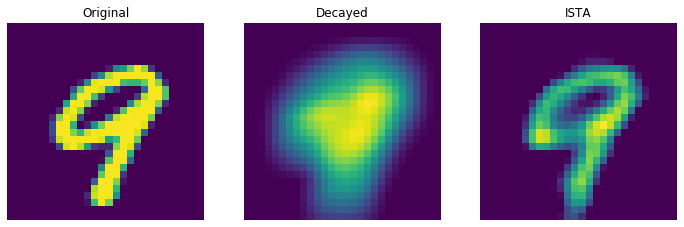

In [183]:
from matplotlib import pyplot as plt
# examples of recovered images
j = 12
for i in range(train_ista.ista.shape[0]):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(test.high[i, j, :].reshape((28, 28)))
    plt.title('Original')
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.imshow(test.low[i, j, :].reshape((28, 28)))
    plt.title('Decayed')
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.imshow(test.ista[i, j, :].reshape((28, 28)))
    plt.title('ISTA')
    plt.axis('off')
    plt.show()